In [86]:
%matplotlib widget
from ipywidgets import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider
import control as ct

#### Constants
# Measured from the arduino
dt_micros = 400  # microseconds per loop
dt = dt_micros / 10**6  # seconds
t_start = 0  # seconds
t_end = 25.05  # seconds
num_points = int(np.ceil((t_end - t_start) / dt))
t_list = np.linspace(t_start, t_end, num_points)


M_BIG_MAGNET = 0.5920  # g
M_MED_MAGNET = 0.2307  # g
M_SMALL_MAGNET = 0.0521  # g
M_NUT = 1.3406  # g

NUM_BIG_MAGNET = 3
NUM_MED_MAGNET = 5
NUM_SMALL_MAGNET = 20
NUM_NUT = 3

MIN_DIST = 0.000001  # m
MAX_DIST = 0.15  # m

m = (
    M_BIG_MAGNET * NUM_BIG_MAGNET
    + M_MED_MAGNET * NUM_MED_MAGNET
    + M_SMALL_MAGNET * NUM_SMALL_MAGNET
    + M_NUT * NUM_NUT
) / 1000  # kg
R = 28.5  # Ohms
g = 9.8  # m/s^2
u_0 = 4 * np.pi * 10e-7
N = 1107  # number of turns
EM_DIAMETER = 0.034  # m
A = np.pi * (EM_DIAMETER / 2.0) ** 2  # m^2

L = 0.051337  # H
PM_GAP = 0.005  # m
EM_TO_HALL = 0.005 # m
B_perm = 0.09219 # T at PM_GAP
C_1 = m*g - (u_0*B_perm)/(4*np.pi*PM_GAP)
C_2 = (N*A)**2 * u_0 / 2.0

x_0 = PM_GAP + EM_TO_HALL
i_0 = x_0 * np.sqrt(C_1 / C_2)
v_0 = i_0 * R
print(f"v_0: {v_0}")

v_0: 31.658079592425324


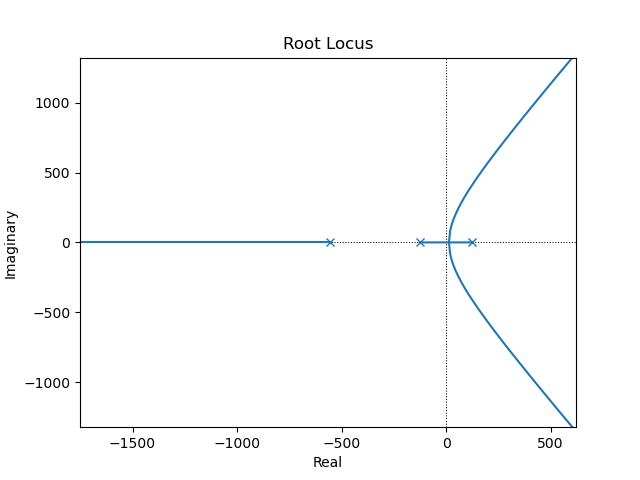

In [51]:
K_P = 8000.0
K_I = 0.0
K_D = 50.0

G_1 = ct.tf([(-2.0*C_2*i_0)/(x_0**2)], [m, 0, (-2.0*C_2*i_0**2)/(x_0**3)])
G_2 = ct.tf([1], [L, R])
G = G_1*G_2
C = -ct.tf([K_D, K_P], [1])

plt.figure()
ct.root_locus(-G, grid=False);
# plt.figure()
# ct.bode_plot(G*C, dB=True, deg=False,omega_limits=(0.1, 100000))
# plt.show()

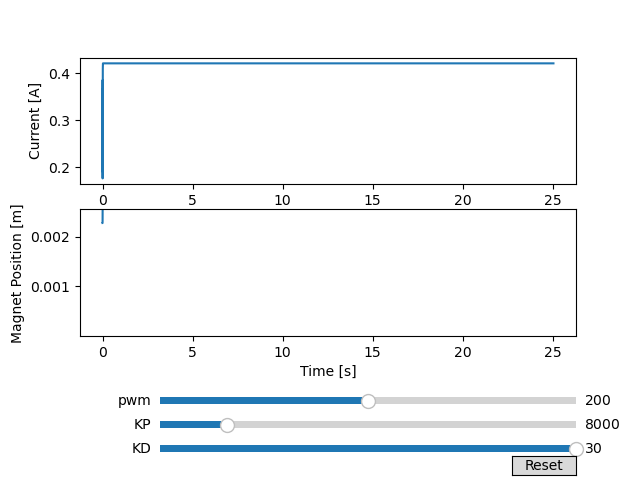

In [49]:
pwm_setpoint = 200.0
v_0 = pwm_setpoint/255.0 * 12.0
i_0 = v_0/R  # amps
x_0 = i_0/np.sqrt(m*g/C_2)

def simulate(K_P, K_D, sigma=0.0001, pwm_setpoint = 200.0):
    global x_0, i_0, v_0
    i = np.zeros(num_points)
    x = np.zeros(num_points)
    x[0] = x_0 + 0.001
    x[1] = x_0 + 0.001
    i[0] = i_0
    e_prev = 0

    for t in range(0, num_points - 2):
        if t == num_points // 2: 
            v_0 = pwm_setpoint / 255.0 * 12.0
            i_0 = v_0 / R  # amps
            x_0 = i_0 / np.sqrt(m * g / C_2)
        disturbance = np.random.normal(0, sigma)
        e = x[t] - x_0 + disturbance
        v_i = np.clip(K_P * e + K_D * (e - e_prev) / dt + v_0, -12.0, 12.0)
        # v_i = K_P * e + K_D * (e - e_prev) / dt + v_0
        i[t + 1] = i[t] + dt * (v_i - R * i[t]) / L
        x[t + 2] = (
            np.clip(
                2 * x[t + 1]
                - x[t]
                + ((dt**2) / (m))
                * (
                    (x[t] * 2 * C_2 * i_0**2) / (x_0**3)
                    - (i[t] * i_0 * 2 * C_2) / (x_0**2)
                ),
                MIN_DIST,
                MAX_DIST,
            ) 
        )
        e_prev = e
    i[-1] = i[-2]
    return i, x


i, x = simulate(K_P, K_D)

fig, axs = plt.subplots(2)

(line_i,) = axs[0].plot(t_list, i, label="Current")
axs[0].set(xlabel="Time [s]", ylabel="Current [A]")

(line_x,) = axs[1].plot(t_list, x, label=f"Model")
axs[1].set(xlabel="Time [s]", ylabel="Magnet Position [m]")

fig.subplots_adjust(bottom=0.3)

axpwm = fig.add_axes([0.25, 0.15, 0.65, 0.03])
pwm_slider = Slider(
    ax=axpwm,
    label="pwm",
    valmin=180,
    valmax=220,
    valinit=200,
    valstep=1,
)

axkp = fig.add_axes([0.25, 0.1, 0.65, 0.03])
kp_slider = Slider(
    ax=axkp,
    label="KP",
    valmin=0,
    valmax=50000,
    valinit=K_P,
    valstep=1000,
)
axkd = fig.add_axes([0.25, 0.05, 0.65, 0.03])
kd_slider = Slider(
    ax=axkd,
    label="KD",
    valmin=0,
    valmax=30,
    valinit=K_D,
    valstep=0.5,
)


def update(val):
    i, x = simulate(kp_slider.val, kd_slider.val, pwm_setpoint=pwm_slider.val)
    line_i.set_ydata(i)
    line_x.set_ydata(x)
    fig.canvas.draw_idle()


axs[1].set_ylim(MIN_DIST, x_0 * 2)
pwm_slider.on_changed(update)
kp_slider.on_changed(update)
kd_slider.on_changed(update)
resetax = fig.add_axes([0.8, 0.01, 0.1, 0.04])
button = Button(resetax, "Reset", hovercolor="0.975")


def reset(event):
    kp_slider.set_val(K_P)
    kd_slider.set_val(K_D)


button.on_clicked(reset)
plt.show()